# 2A.ml - Arbres, forêts aléatoires et extensions - énoncé- Gabriel ROMON

Cet énoncé est une version modifiée de celui de Xavier Dupré.

In [1]:
%matplotlib inline
import urllib.request
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Données

Le package `pickle` permet de sauvegarder n'importe quel objet Python (liste, numpy array, ...) en un fichier afin que cet objet puisse être sauvegardé ou partagé. C'est très pratique lorsque l'objet en question est le fruit d'un calcul long (poids d'un réseau de neurones, hyperparamètres d'un modèle, ...).

On télécharge le fichier `.pickle` depuis mon Github et on l'ouvre. C'est une liste de 3 éléments `[X, y, X_private]`. Le but est d'entraîner un modèle sur `X, y` et de prédire `y_private` (qui est une variable continue).

Vous m'enverrez un fichier `.pickle` contenant vos prédictions et je vais évaluer le MSE correspondant: $$\text{MSE}=\frac 1n\sum_{i=1}^n (y_i-\hat{y}_i)^2$$

C'est un mini-Kaggle !

In [2]:
url = 'https://github.com/gabsens/Python-for-Data-Scientists-ENSAE/raw/master/TD2/data.pickle'
urllib.request.urlretrieve(url, './data.pickle')

with open("data.pickle", "rb") as f:
    X, y, X_private = pickle.load(f)

In [3]:
X.shape

(15480, 8)

In [4]:
X_private.shape

(5160, 8)

# Exercice 1: Mini-Kaggle, tuning de modèles

Afin de juger de la qualité des modèles entrainés, il faut couper le jeu de données en deux.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
X_train.shape

(11610, 8)

In [7]:
X_test.shape

(3870, 8)

## a) Entraîner une régression linéaire

On commence toujours par le modèle le plus simple: la régression linéaire. C'est un modèle peu complexe, mais au moins il ne risque pas d'overfitter.

Vous devez obtenir à peu près le même MSE sur le train et le test. Ces scores constituent la baseline.

## b) Entraîner un arbre de décision

Ne touchez à aucun hyperparamètre dans un premier temps.

Le MSE sur le train est quasi 0, alors que le MSE sur le test est proche de celui de la régression linéaire. Le modèle overfit terriblement !  

Il va falloir jouer sur les hyperparamètres. Pour cela, il faut comprendre comment fonctionnent les arbres de décision...
***

Les arbres de décision de Scikit-Learn sont des arbres binaires (chaque noeud a exactement 2 fils). Ils sont construits récursivement en partant de la racine. Regardez l'arbre ci-dessous: étant donné un nouvel example $(x_1,\ldots,x_8)$, on regarde d'abord si $x_1\leq 5.148$. Si c'est le cas, on regarde ensuite si $x_1\leq 3.071$. Si oui, le $\hat y$ prédit est $1.352$. Sinon, on regarde si $x_6\leq 2.344$. Si c'est le cas, on prédit $2.841$, et sinon on prédit $1.895$.

A chaque noeud on peut associer les exemples de la base d'entrainement (les lignes de `X_train`) qui vérifient les conditions menant à ce noeud. Le nombre de telles lignes est donné par `samples=...`, la valeur $\hat y$ que l'arbre leur assigne est donnée par `value=...`, et le MSE correspondant à cette prédiction est donné par `mse=...`.  
Par exemple, dans l'arbre ci-dessous, considérons la condition $$(x_1\leq 5.148) \text{ and } (x_1> 3.071) \text{ and } (x_6>2.344)$$
$3861$ lignes la vérifient et la prédiction associée à ces lignes est $1.895$.

Décrivons succinctement l'algorithme de croissance des arbres. Un noeud de l'arbre est entièrement caractérisé par la variable $x_k$ et le seuil $t_k$ à partir desquels la condition $x_k\leq t_k$ est créée. La racine de l'arbre est créée en cherchant $(k, t_k)$ qui minimise $$\frac{m_{\text{gauche}}}{m} \text{MSE}_{\text{gauche}}+\frac{m_{\text{droite}}}{m} \text{MSE}_{\text{droite}}$$
où $m$ est le nombre total de samples (le nombre de lignes de `X_train`), $m_{\text{gauche}}$ est le nombre de samples qui vérifient la condition $x_k\leq t_k$ et $\text{MSE}_{\text{gauche}} = \sum_{i \in \text{gauche}} (y^{(i)}-\hat y_{\text{gauche}}
)^2$ où la valeur prédite dans le fils gauche est $\hat y_{\text{gauche}} = \frac{1}{m_{\text{gauche}}} \sum_{i \in \text{gauche}} y^{(i)}$.  
La croissance de l'arbre se poursuit en répétant le procédé sur le fils gauche et le fils droit de la racine (etc).

Il faut des conditions d'arrêt qui disent quand stopper la croissance de l'arbre. Si l'arbre est trop complexe (trop de noeuds/feuilles), il va overfitter les données. C'est là qu'interviennent les hyperparamètres:
* `max_depth`: la profondeur maximale de l'arbre 
* `max_leaf_nodes`: nombre maximal de feuilles dans l'arbre
* `min_samples_split`: un noeud qui a moins de `min_samples_split` samples est automatiquement une feuille
* `min_samples_leaf`: nombre minimum de samples dans chaque noeud (un split ne sera envisagé que si il y a au moins `min_samples_leaf` samples dans le fils gauche et `min_samples_leaf` samples dans le fils droit).


En mettant `max_depth` petit, `max_leaf_nodes` petit, `min_samples_split` grand, et `min_samples_leaf` grand, on limite l'overfitting.

In [8]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

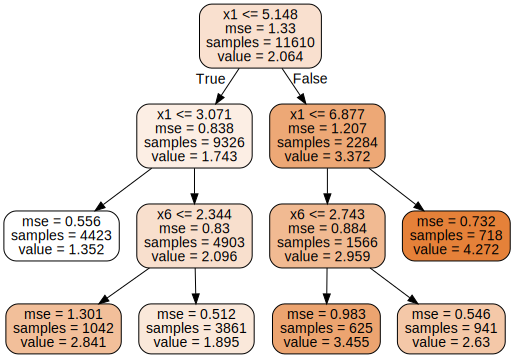

In [11]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=6)
tree.fit(X_train, y_train)

export_graphviz(
        tree,
        out_file="./regression_tree.dot",
        feature_names=["x"+str(i) for i in range(1,9)],
        rounded=True,
        filled=True
    )
Source.from_file("./regression_tree.dot")

***

## Question importante: comment choisir les hyperparamètres ?

On ne peut pas simplement essayer différentes hyperparamètres et consulter la performance sur `X_test`. Si on fait ça, on va overfit le `X_test` !

Il faut choisir les hyperparamètres par validation croisée ($k$-fold cross-validation).

ci-dessous les perfs du meilleur modèle (sur chacun des 10 folds):

In [58]:
[-v[tree_search.best_index_] for (k,v) in tree_search.cv_results_.items() if k.startswith('split')]

[0.3967812850061739,
 0.41345941139209036,
 0.400720122410235,
 0.47374972605831284,
 0.38450011085565255,
 0.4202797996579079,
 0.4043485602541037,
 0.422875591800359,
 0.4075115015096375,
 0.3906582167179846]

La moyenne de ces MSE est directement accessible:

In [59]:
-tree_search.best_score_

0.41148843256624573

Les meilleurs hyperparamètres:

In [ ]:
tree_search.best_params_

La fonction `GridSearchCV` prend les meilleurs hyperparamètres et les utilise pour entrainer le modèle sur tout `X_train`. On accède au modèle final avec `tree_search.best_estimator_`:

Le modèle overfit certes, mais le MSE sur le test est très proche du MSE calculé par cross-validation. Donc on arrive bien à prévoir la capacité du modèle à généraliser.

## c) Entraîner un random forest

Ne touchez à aucun hyperparamètre dans un premier temps.

Comme attendu, le modèle overfit beaucoup.

Grossièrement, un random forest est une moyenne d'un grand nombre d'arbres de décision. Les hyperparamètres sont donc très similaires aux précédents (il faut en plus choisir le nombre d'arbres `n_estimators`).

In [64]:
[-v[rf_search.best_index_] for (k,v) in rf_search.cv_results_.items() if k.startswith('split')]

[0.31412747224478743,
 0.33240025878389157,
 0.3205169171798233,
 0.35747842327414614,
 0.31595881523786473,
 0.3494175731191536,
 0.31592927905735,
 0.3746973167349527,
 0.30656018536020563,
 0.31199181796390957]

In [65]:
-rf_search.best_score_

0.3299078058956084

In [ ]:
rf_search.best_params_

In [67]:
rf = rf_search.best_estimator_
print('MSE:', 'train:', mean_squared_error(y_train, rf.predict(X_train)),
              'test:', mean_squared_error(y_test, rf.predict(X_test))
     )

MSE: train: 0.24940160680121298 test: 0.33605346214901327


2ème tentative en raffinant ce qu'on a trouvé

In [69]:
[-v[rf_search.best_index_] for (k,v) in rf_search.cv_results_.items() if k.startswith('split')]

[0.28197782081362294,
 0.2916967889629732,
 0.27348200022477076,
 0.3094498074419222,
 0.27303765168208033,
 0.2978301724111948,
 0.272525493710379,
 0.3253057128965016,
 0.2531161937171129,
 0.2663949656702875]

In [70]:
-rf_search.best_score_

0.28448166075308456

In [ ]:
rf_search.best_params_

In [73]:
rf = rf_search.best_estimator_
print('MSE:', 'train:', mean_squared_error(y_train, rf.predict(X_train)),
              'test:', mean_squared_error(y_test, rf.predict(X_test))
     )

MSE: train: 0.14317293137433595 test: 0.28511666703503513


On a un MSE en cross-val sur le train et un MSE sur le test proches de $0.285$, c'est bien !

En tunant un peu plus j'arrive à un MSE de $0.260$ (sur le private).

## d) Entraîner un xgboost

Les arbres boostés ont été utilisés pour remporter de nombreux Kaggle, on est quasi sûr d'avoir un meilleur MSE.

En tunant légèrement j'ai un MSE de $0.220$ sur le private.

***

Le modèle Lasso permet de sélectionner des variables, une forêt aléatoire produit une prédiction comme étant la moyenne d'arbres de régression. Et si on mélangeait les deux ?

# Exercice 2: Lasso et random forests

## a) calculer soi-même la moyenne des prédictions des arbres de la forêt aléatoire

C'est peut-être inutile mais ça permet de s'assurer que la prédiction d'une forêt aléatoire est bien issue de la moyenne des prédictions d'un ensemble d'arbre de régression.

## b) pondérer les arbres à l'aide d'une régression linéaire

La forêt aléatoire est une façon de créer de nouvelles features, 100 exactement qu'on utilise pour caler une régression linéaire. A vous de jouer.

## c) que se passe-t-il si on remplace la régression linéaire par un Lasso ?

Petit rappel : le [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) est une façon de sélectionner les variables.

## d) tracer l'évolution de la performance et du nombre d'arbres en fonction de alpha